<a href="https://colab.research.google.com/github/ezrafield/ibm-certificate-final/blob/main/find_matrix_rotate_by_SIFT_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from matplotlib.cbook import violin_stats
from numpy.core.arrayprint import format_float_scientific
import numpy as np
import cv2
import matplotlib.pyplot as plt

class RotateMatrix2D:
    def __init__(self, ImageInput1, ImageInput2 = False, degree = 0):
        # image, width, height, MatrixOutput, view
        SIZE = ImageInput1.shape
        self.W, self.H = SIZE[0], SIZE[1]
        self.SIZE = SIZE[:2]
        self.degree = degree
        self.img1 = ImageInput1
        self.img2 = ImageInput2

    #rotate
    def rotateImage(self, degree = 0, viewMatrixRotate = False):
    # quay hình img1 (ảnh gốc)
    # Input: 
    #  - degree : góc quay (theo chiều kim đồng hồ)
    #  - viewMatrixRotate : hiển thị matrix biểu diễn quay không (để so sánh kết quả model)
    # Output: img2 : ảnh sau quay (dạng opencv numpy array)
        if degree == 0:
          degree = self.degree
        height, width = self.SIZE[:2]
        center = (width / 2, height / 2)
        MatrixRotate = cv2.getRotationMatrix2D(center=center, angle= degree, scale=1)
        img2 = cv2.warpAffine(self.img1, MatrixRotate, self.SIZE)
        img2 = cv2.resize(img2, self.SIZE, interpolation=cv2.INTER_AREA)
        if viewMatrixRotate == True:
          print(MatrixRotate)
        return img2

    #SIFT
    def sift(self, img1, img2, show = True):
      # SIFT agorithm cho 2 ảnh
      # Input:
      # - img1, img2 : 2 ảnh cần xét (dạng opencv numpy array)
      # - show : hiện thị biểu diễn 5 match đầu của kết quả SIFT để dễ hình dung
      # Output: 
      # - matches : tập mã hóa match 2 ảnh
      # - keypoints_1, keypoints_2 : tập các đầu mút của tập match ở ảnh 1, ảnh 2
        sift = cv2.SIFT_create()
        keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

        # feature matching
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

        matches = bf.match(descriptors_1, descriptors_2)
        matches = sorted(matches, key=lambda x: x.distance)

        if show == True:
            img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:5], img2, flags=2)
            plt.imshow(img3)
            plt.show()

        return matches, keypoints_1, keypoints_2

    #keypoint coordinate
    def siftKeypointCoord(self, siftResult, numberCheckExample = 0):
      # tìm tọa độ các điểm được match (giải mã matches)
      # Input:
      # - siftResult: kết quả SIFT (đúng form theo method sift trên)
      # - numberCheckExample: hiện 1 vài phần tử đầu tiên để check
      # Output:
      # - list_kp1, list_kp2: tọa độ các điểm đầu mút match tương ứng
        # Initialize lists
        list_kp1 = []
        list_kp2 = []
        matches, keypoints_1, keypoints_2 = siftResult[0], siftResult[1], siftResult[2]
        # For each match...
        for mat in matches:

            # Get the matching keypoints for each of the images
            img1_idx = mat.queryIdx
            img2_idx = mat.trainIdx

            # x - columns
            # y - rows
            # Get the coordinates
            (x1, y1) = keypoints_1[img1_idx].pt
            (x2, y2) = keypoints_2[img2_idx].pt

            # Append to each list

            if (x1, y1) in list_kp1:
                continue
            list_kp1.append((x1, y1))
            list_kp2.append((x2, y2))

        if numberCheckExample > 0:
            list_sorted_matches_pt = [[list_kp1[i], list_kp2[i]] for i in range(len(list_kp1))]
            print(len(list_sorted_matches_pt))
            print(list_kp1[:numberCheckExample])
            print(list_kp2[:numberCheckExample])

        return list_kp1, list_kp2

    # find matrix rotate (matrix homographic)
    def findMatrixRotate(self, image1, image2, view = True):
      # tìm matrix quay của 2 ảnh
      # Input:
      # - image1, image2: 2 ảnh cần xét
      # - view: hiển thị ảnh kết quả của algorithm
      # Output:
      # - matrix: matrix quay nhận dạng từ algorithm 
        img2v = image2.copy()
        siftResult = self.sift(img1 = image1, img2 = image2, show = False)
        list_kp1, list_kp2 = self.siftKeypointCoord(siftResult = siftResult, numberCheckExample= 0)

        pts1 = np.float32(list_kp1[:4])
        pts2 = np.float32(list_kp2[:4])

        matrix = cv2.getPerspectiveTransform(pts2, pts1)
        if view == True:
            imgOutput = cv2.warpPerspective(img2v, matrix, (self.W, self.H), flags=cv2.INTER_LINEAR)
            plt.imshow(imgOutput)
            plt.show()
        elif view == False:
            print(matrix)
        
        return matrix
    

## Test

In [44]:
import urllib
SIZE = (500, 500)

img1 = cv2.imread('/content/testimg.jpg', 0)


In [45]:
# def __init__(self, ImageInput1, ImageInput2 = False, degree = 0):
classtest = RotateMatrix2D(img1, degree = 30)

In [46]:
# def rotateImage(self, degree = 0, viewMatrixRotate = False)
# return img2
img2 = classtest.rotateImage(viewMatrixRotate = True)

[[   0.8660254     0.5        -311.75883581]
 [  -0.5           0.8660254   396.50018505]]


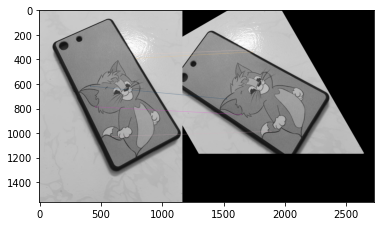

In [47]:
#SIFT
# def sift(self, img1, img2, show = True)
# return matches, keypoints_1, keypoints_2
siftresult = classtest.sift(img1, img2)

In [48]:
# def siftKeypointCoord(self, siftResult, numberCheckExample = 0)
# return list_kp1, list_kp2
list_kp1, list_kp2 = classtest.siftKeypointCoord(siftresult, numberCheckExample = 4)

926
[(773.9361572265625, 362.53326416015625), (792.438720703125, 392.1288146972656), (418.2813415527344, 618.1231079101562), (599.684814453125, 1026.70849609375)]
[(539.6239013671875, 323.6310729980469), (570.4904174804688, 339.97802734375), (359.4600830078125, 722.8089599609375), (720.9562377929688, 985.9152221679688)]


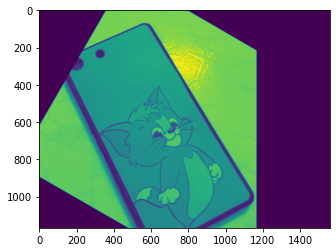

In [49]:
# def findMatrixRotate(self, image1, image2, view = True)
# return matrix
matrixlast = classtest.findMatrixRotate(img1, img2)

In [50]:
matrixlast

array([[ 8.69061646e-01, -5.01996584e-01,  4.68798534e+02],
       [ 5.03204577e-01,  8.66032734e-01, -1.88642659e+02],
       [ 4.48799886e-06, -2.02508849e-06,  1.00000000e+00]])